# Модель подбора оптимального тарифа

**Содержание:**   
<a id="start"></a>
1. [Загрузка данных и общая информация](#section_1)  

2. [Исследовательский анализ данных](#section_2)  

3. [Разделение данных на выборки](#section_3)   
    
4. [Исследование моделей](#section_4)  
 4.1. [Функции построения моделей](#section_4_1)  
 4.2. [Модель LogisticRegression](#section_4_2)  
 4.3. [Модель DecisionTreeClassifier](#section_4_3)  
 4.4. [Модель RandomForestClassifier](#section_4_4)  
 4.5. [Модель CatBoostClassifier](#section_4_5)
 
5. [Тестирование лучшей модели](#section_5)  
    
6. [Общий вывод](#section_6)  

**Заказчик исследования:** оператор мобильной связи.

**Цель исследования:** создание модели прогнозирования, способной по поведению пользователя определить максимально подходящий ему тариф: «Смарт» или «Ультра».

**Требования к модели:**  метрика accuracy не должна быть менее 0.75.

**Описание данных**

Исходные данные содержатся в следующих файле "users_behavior.csv":
 - "сalls" — количество звонков,
 - "minutes" — суммарная длительность звонков в минутах,
 - "messages" — количество sms-сообщений,
 - "mb_used" — израсходованный интернет-трафик в Мб,
 - "is_ultra" — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  
 
Целевой признак - is_ultra;  
Исходные данные уже предобработаны.  

## Загрузка данных и общая информация
<a id="section_1"></a>

**Импорт библиотек**

In [1]:
import math
import timeit

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from numpy import sqrt
from numpy import argmax
from optuna.distributions import IntDistribution as intd
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

Создаем датафрейм:

In [2]:
df = pd.read_csv('users_behavior.csv')

Выводим общую информацию по датафрейму:

In [3]:
print('Размер датафрейма:')
print(df.shape)
print('_' * 50)
print()
print('Общая информация о датафрейме:')
print(df.info(memory_usage='deep'))
print('_' * 50)
print()
print('Несколько строк датафрейма:')
display(df.sample(random_state=0, n=5))
print('_' * 50)
print()
print('Количество дубликатов:')
print(df.duplicated().sum())
print('_' * 50)  
print()
print('Описательная статистика числовых значений:')
display(df.describe().T)
print('_' * 50)
print()
print('Количество пропусков:')
print(df.isna().sum())
print()
print('Количество пропусков в процентах:')
print(df.isna().mean()*100)  

Размер датафрейма:
(3214, 5)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
__________________________________________________

Несколько строк датафрейма:


,calls,minutes,messages,mb_used,is_ultra
2568,82.0,580.09,96.0,21463.80,0
2200,29.0,217.15,46.0,16933.72,0
306,36.0,250.88,49.0,18965.02,0
831,133.0,972.70,83.0,38552.62,0
2781,25.0,155.55,98.0,17856.19,0


__________________________________________________

Количество дубликатов:
0
__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


__________________________________________________

Количество пропусков:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Количество пропусков в процентах:
calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64


Проверяем датафрейм на дисбаланс классов:

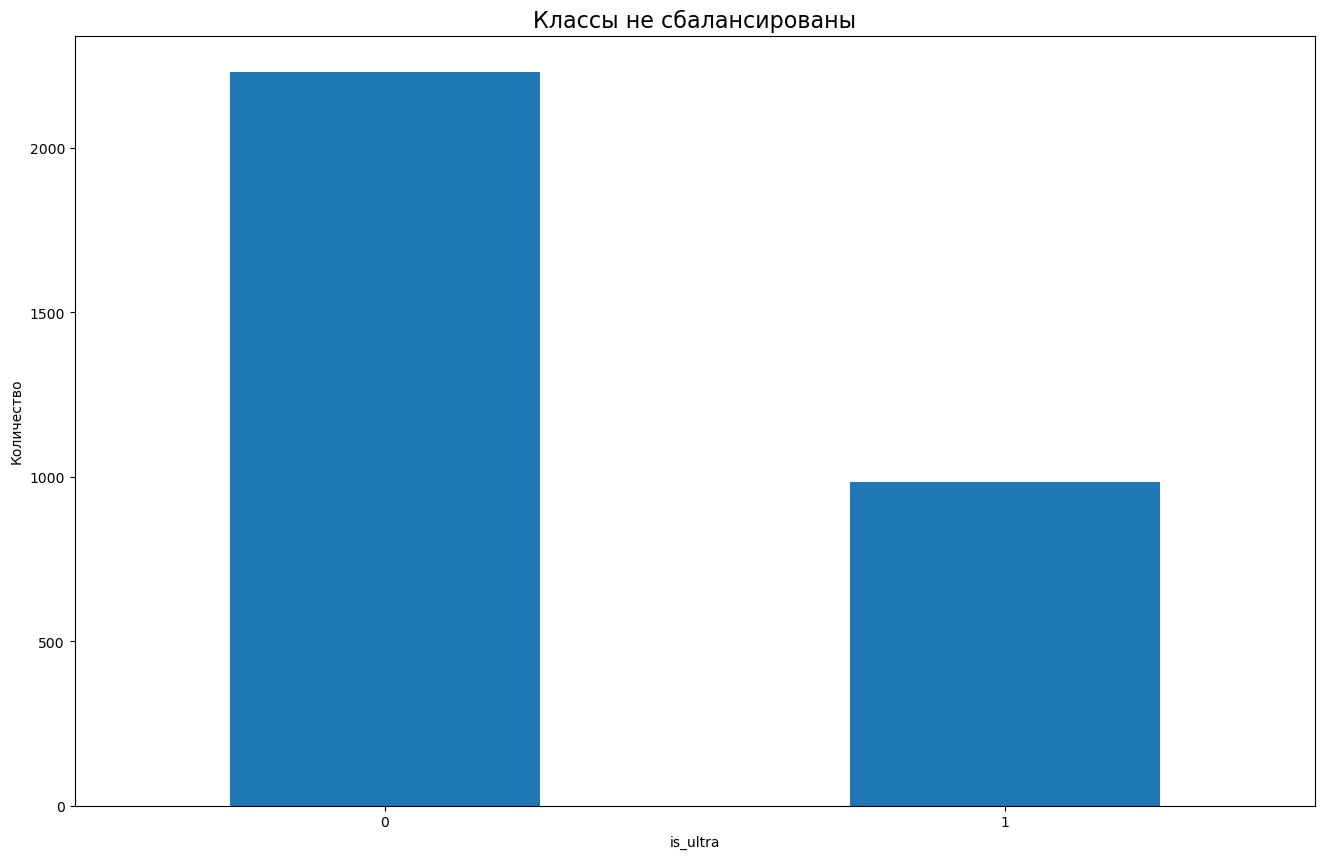

In [4]:
df_all_size = df.groupby('is_ultra')['calls'].count()
fig = plt.figure(figsize=(16,10))
ax = df_all_size.plot.bar()
plt.title('Классы не сбалансированы', fontsize=16)
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

**Вывод:**  
1. В датафрейме содержатся 3214 строк и 5 столбцов. Объем датафрейма - 125.7 KB.
2. Параметры "calls", "minutes", "messages", "mb_used" имеют тип "float64", а "is_ultra" - "int64".
3. Пропущенные значения отсутствуют.
4. Пользователей тарифа "Ультра" от общего количества представленных в датафрейме пользователей - 30.6%.

[Вернуться к содержанию](#start) 

## Исследовательский анализ данных
<a id="section_2"></a>

Проверяем данные на выбросы:

In [5]:
def anomaly(df):
    '''функция диаграммы размаха'''
    
    for i in df.drop(['is_ultra'], axis=1).columns:
        plt.figure(figsize=(12,10))
        sns.boxplot(y=i, x='is_ultra', data=df)
        plt.show()

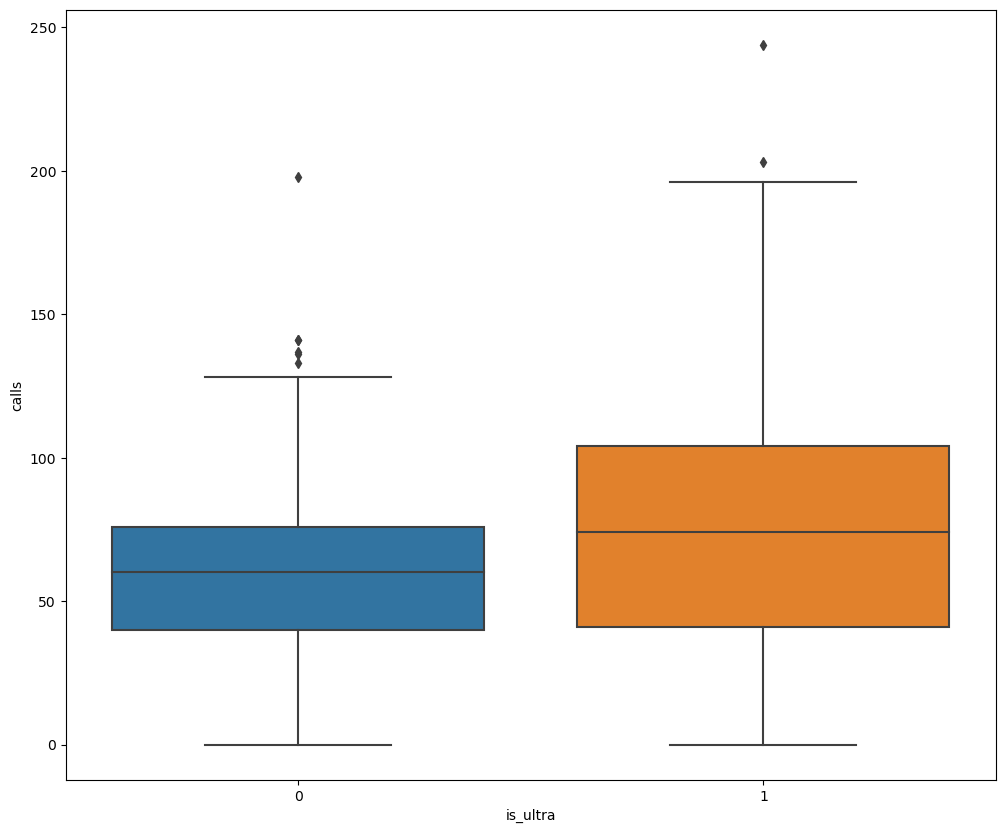

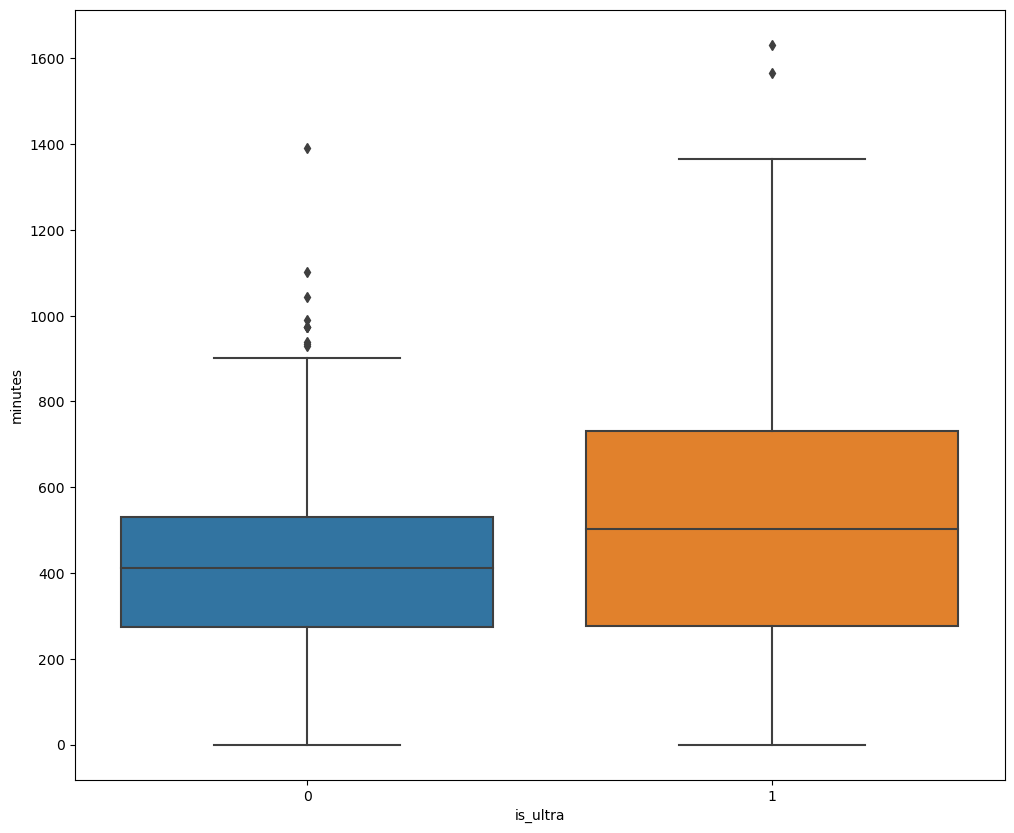

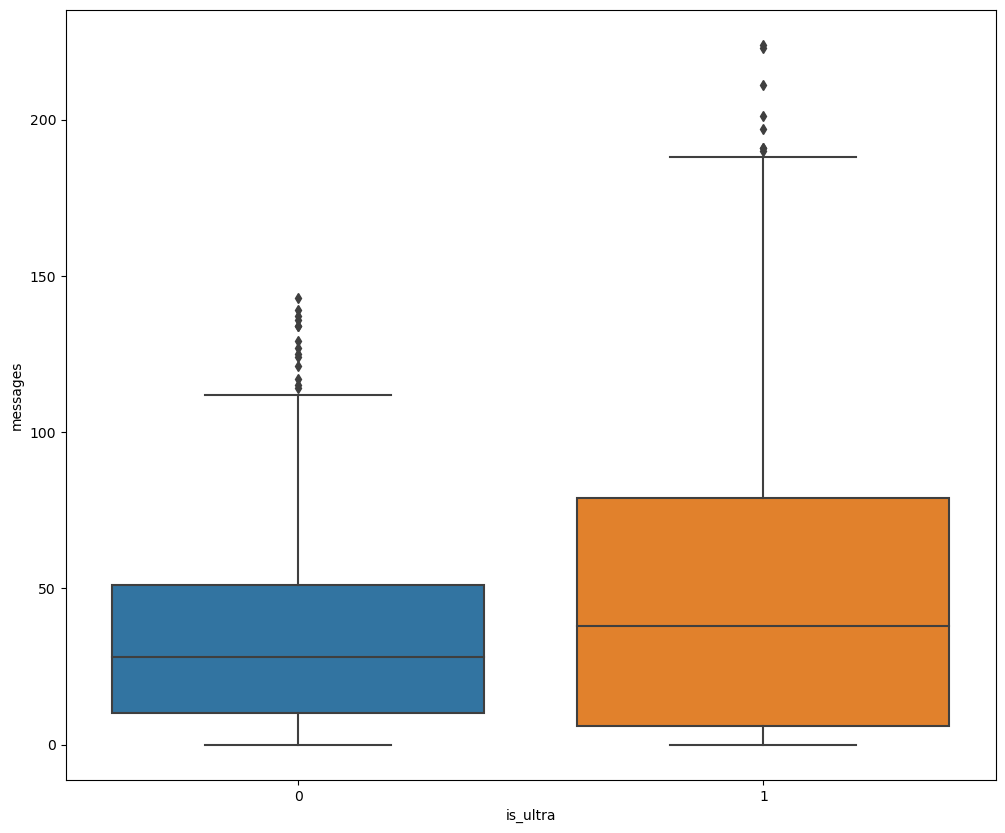

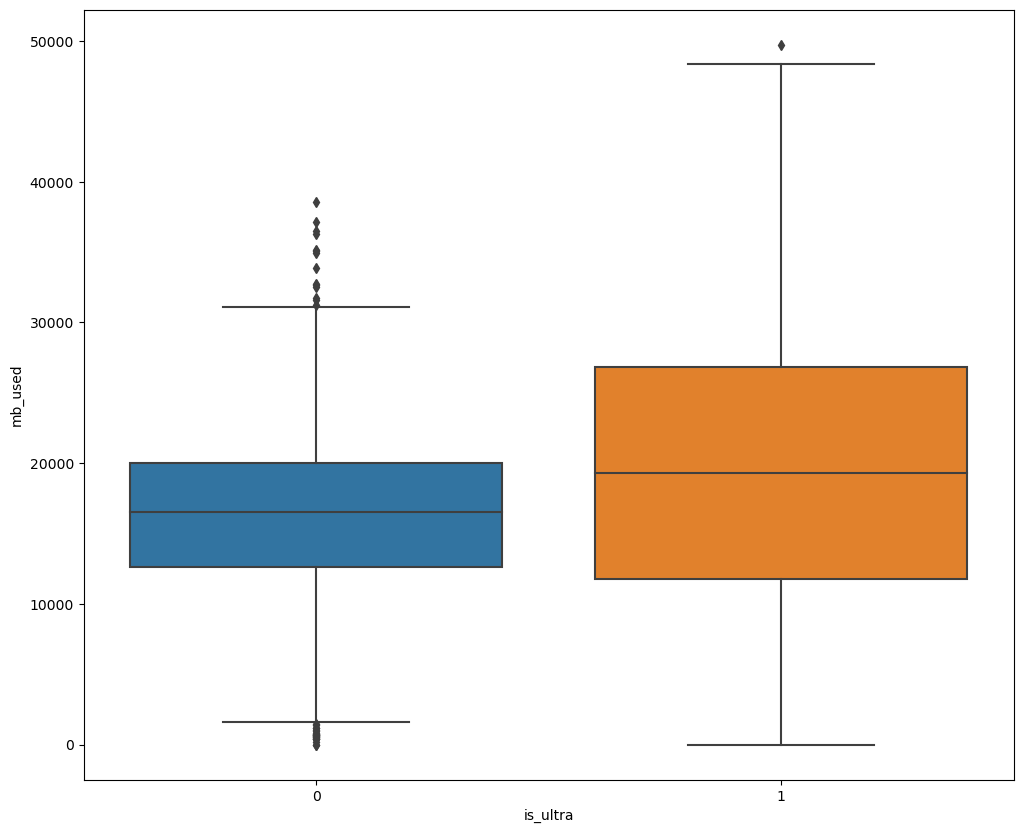

In [6]:
anomaly(df)

У тарифа "Ультра" больше и диапазон распределения значений и медианы признаков.  
У обоих тарифов присутствуют выбросы значений признаков за первый и третий квантили. Но если тарифы предусматривают возможность пользования услугами в таких объемах, считать эти выбросы аномальными значениями нельзя.

Строим гистограммы распределения признаков:

In [7]:
def distribution(analysis):
    for i in df.drop(['is_ultra'], axis=1).columns:
        fig = plt.figure(figsize=(16,10))
        ax = sns.histplot(x=i, data=df, hue='is_ultra', bins=20)
        label = 'Quantity'
        plt.title('Распределение признака {}'.format(i), fontsize=16)
        plt.ylabel(label)
        plt.show()

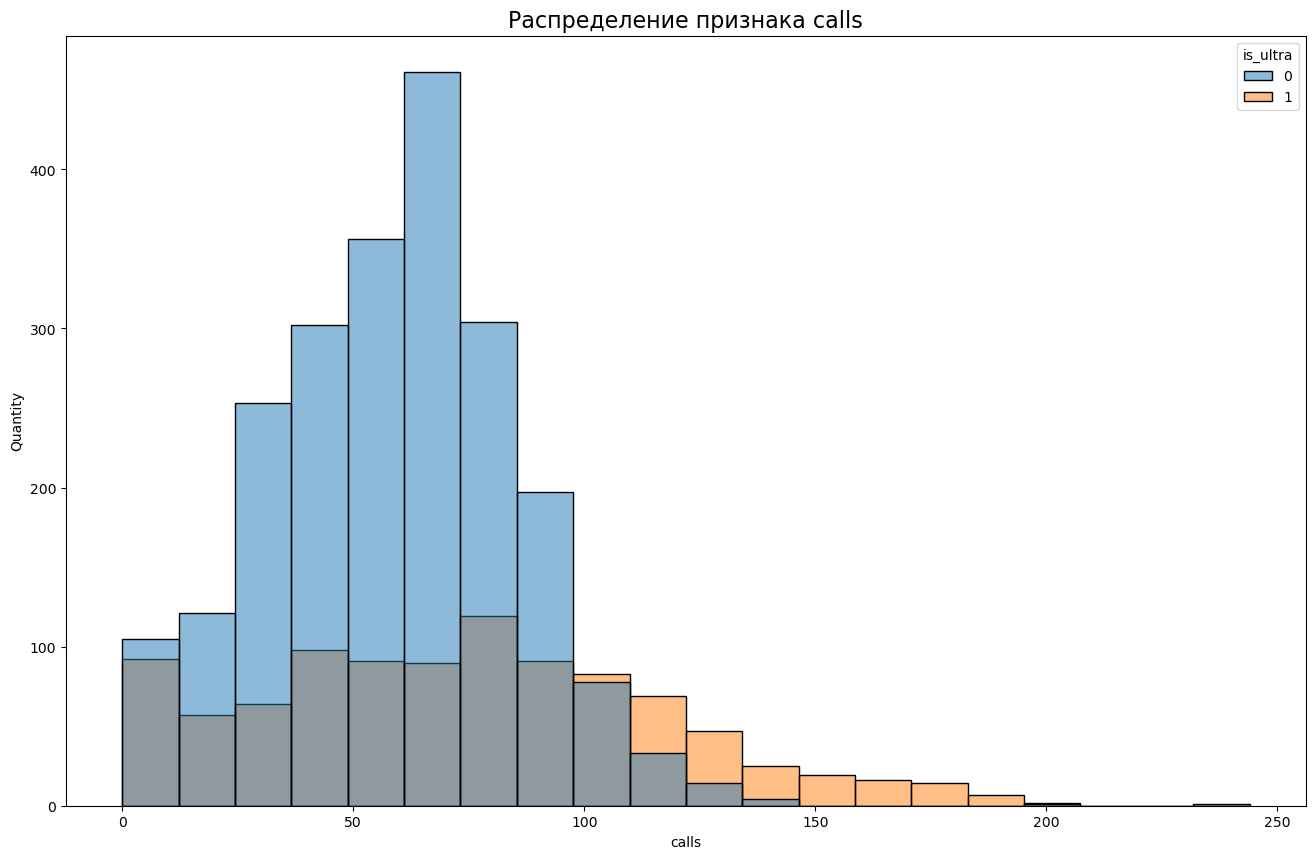

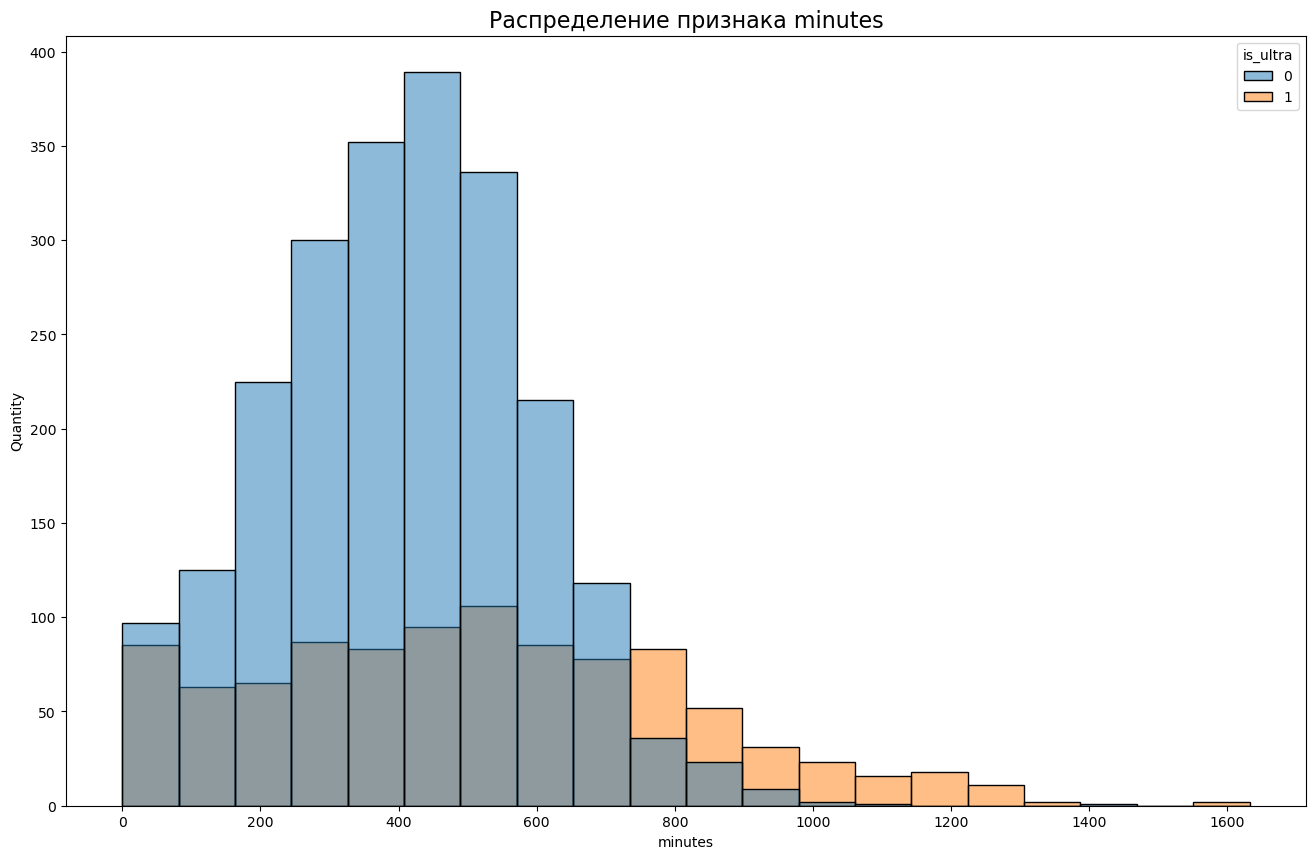

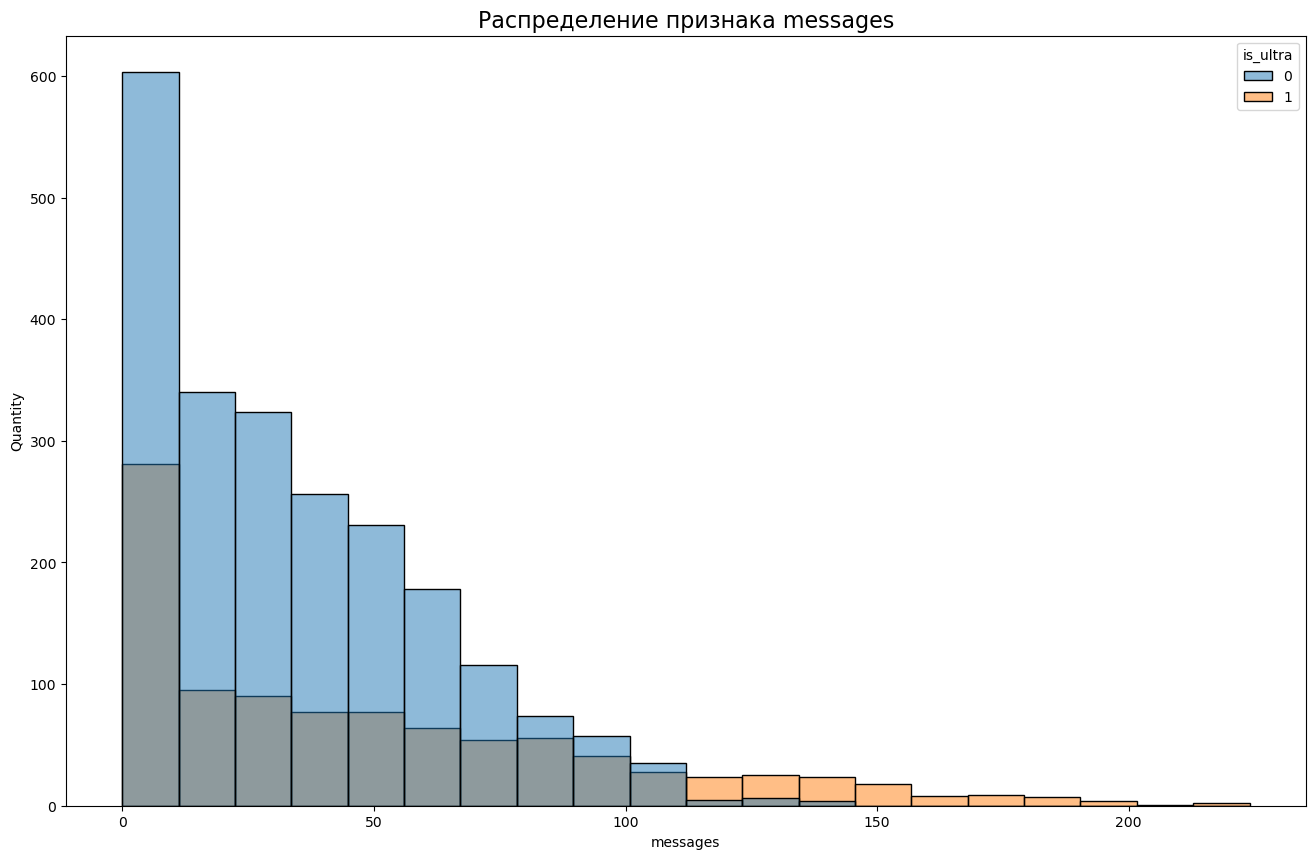

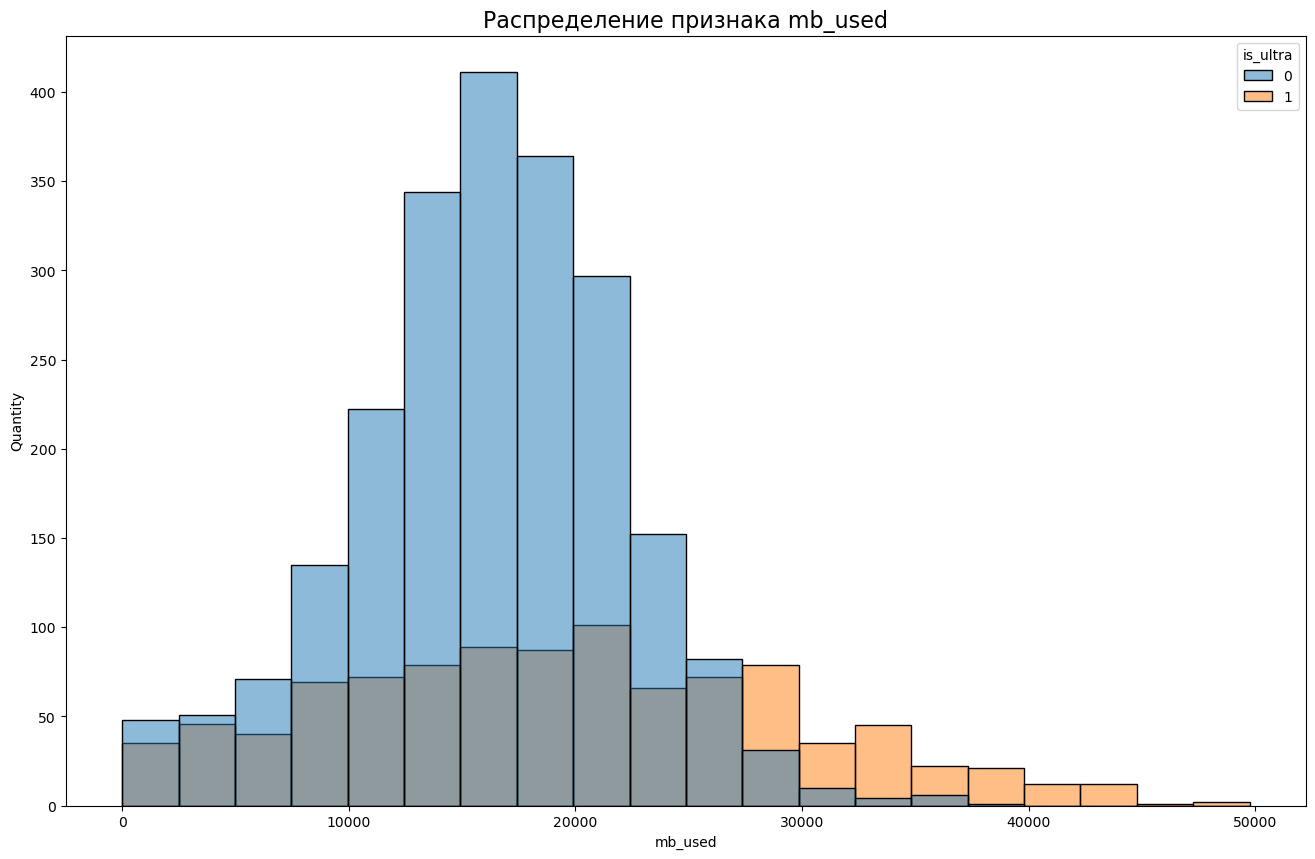

In [8]:
distribution(df)

Распределения признаков имеют положительную асимметрию.  
Тариф "Ультра" имеет более пологое распределение признаков.  
У тарифа смарт наблюдаются ярковыраженные пики:  
- calls: 25-100;
- minutes: 190-700;
- mb_used: 10000-25000.

Проверяем признаки на корреляцию:

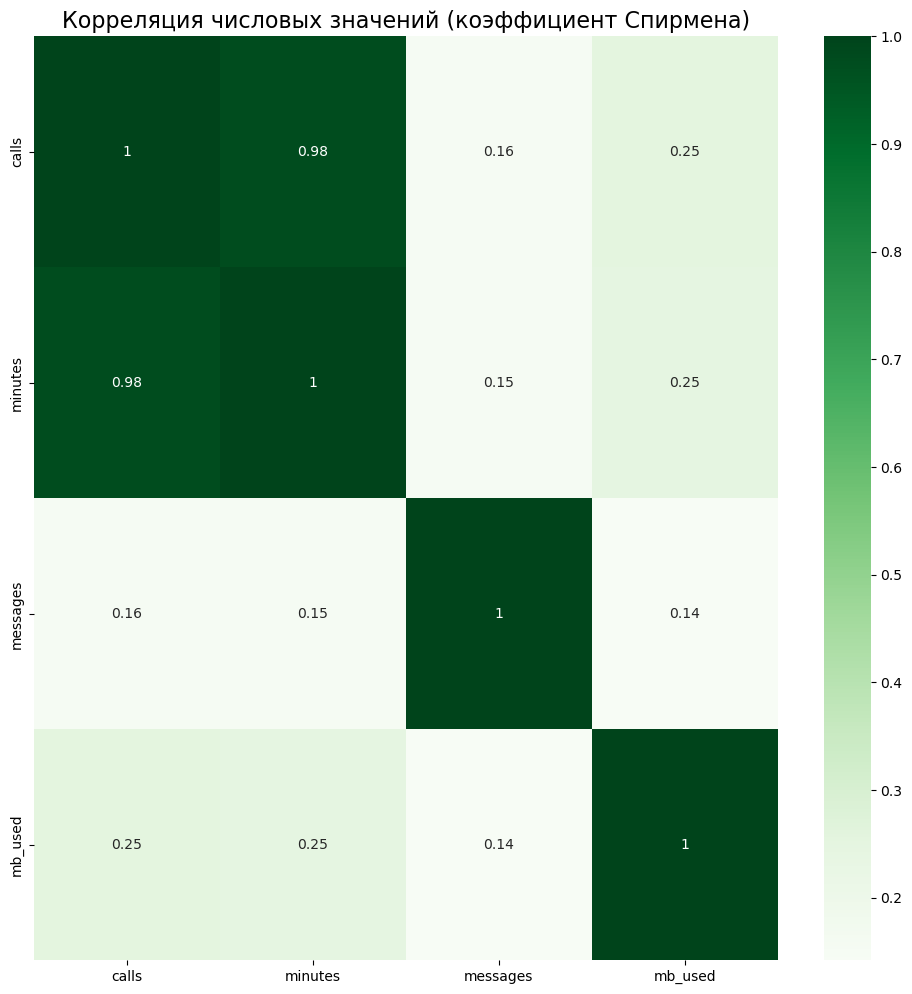

In [9]:
fig = plt.subplots(figsize=(12, 12))
sns.heatmap(df.drop(['is_ultra'], axis=1).corr(method = 'spearman'), annot = True, cmap = 'Greens')
plt.title('Корреляция числовых значений (коэффициент Спирмена)', fontsize=16)
plt.show()

Высокий уровень корреляции наблюдается у признаков "calls" и "minutes". На этом основании исключаем признак "calls" из исследования:

In [11]:
df = df.drop(['calls'], axis=1)

**Вывод:**  
1. У тарифа "Ультра" больше и диапазон распределения значений и медианы признаков.  
У обоих тарифов присутствуют выбросы значений признаков за первый и третий квантили. Но если тарифы предусматривают возможность пользования услугами в таких объемах, считать эти выбросы аномальными значениями нельзя.
2. Распределения признаков имеют положительную асимметрию.  
Тариф "Ультра" имеет более пологое распределение признаков.  
У тарифа смарт наблюдаются ярковыраженные пики:  
- calls: 25-100;
- minutes: 190-700;
- mb_used: 10000-25000.
3. Высокий уровень корреляции наблюдается у признаков "calls" и "minutes". На основании этого признак "calls" исключен из исследования.

[Вернуться к содержанию](#start) 

## Разделение данных на выборки
<a id="section_3"></a>

Задаем значение параметра random_state:

In [12]:
RS = 42

Создаем переменные для признаков и целевого признака:

In [13]:
X = df.drop(['is_ultra'], axis=1)
y = df['is_ultra']

Разделяем данные на обучающую и тестовую выборки в пропорциях 70%-30%:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RS)
print(f'Размер обучающей выборки: {X_train.shape[0]}')
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 2249
Размер тестовой выборки: 965


Для моделей LogisticRegression, DecisionTreeClassifier и RandomForestClassifier масштабируем числовые признаки. Для модели CatBoostClassifier будут использоваться немасштабированные данные.

In [15]:
class ScalerTransformation(BaseEstimator, TransformerMixin):
    '''класс обучения и трансформации для масштабирования числовых признаков'''
    scaler = StandardScaler()
    
    def fit(self, X, y=None):
        X = X.copy()                                                     # делаем копию матрицы признаков
        self.scaler.fit(X)                           # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X, y=None):
        X = X.copy()                                                           # делаем копию матрицы признаков
        X = self.scaler.transform(X)   # масштабируем числовые значения
        return X

## Исследование моделей
<a id="section_4"></a>

Гиперпараметры подбираются с помощью OptunaSearchCV.  
Лучшую модель определяем по метрике ROC-AUC. Поскольку метрика не восприимчива к дисбалансу классов, балансировку не проводим. Вместо балансировки классов находим оптимальный порог и производим предсказание с учетом его.  
В целях определения качества определения каждого из классов дополнительно рассчитываем метрики F1 и Recall.

### Функции построения моделей
<a id="section_4_1"></a>

In [16]:
def metrics(model, params, model_name):
    '''функция обучения моделей и расчёта метрик'''
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)                               # отключаем логгирование
    model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)                     # передаем данные в OptunaSearchCV
    start_time = timeit.default_timer()                                                # начальное время обучения
    model.fit(X_train, y_train)                                                        # обучаем модель
    time_fit = timeit.default_timer() - start_time                                     # длительность обучения
    start_time = timeit.default_timer()                                                # начальное время предсказания
    
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    
    
    roc_auc = model.best_score_                                                        # метрика roc_auc
    y_pred = model.best_estimator_.predict(X_train)                                    # делаем предсказание
    time_pred = timeit.default_timer() - start_time                                    # длительность предсказания
    
    recall = recall_score(y_train, y_pred).round(3)                                    # метрика recall
    f1 = f1_score(y_train, y_pred).round(3)                                            # метрика f1
    accuracy = accuracy_score(y_train, y_pred).round(3) 
    
    print('Roc_Auc: {}'.format(roc_auc))                                               # выводим метрику roc_auc
    print('Recall: {}'.format(recall))                                                 # выводим метрику recall
    print('F1: {}'.format(f1))                                                         # выводим метрику f1
    print('Accuracy: {}'.format(accuracy))                                             # выводим метрику accuracy
    
    return model, accuracy, recall, roc_auc, f1, time_fit, time_pred

### Модель LogisticRegression
<a id="section_4_2"></a>

Подбираемый гиперпараметр - "C". Классы сбалансированы методом взвешивания классов.

In [17]:
params_lr = {'C': intd(1, 10, False, 1)}                                     # значения гиперпараметров модели для подбора
new_params_lr = {'logisticregression__' + key: params_lr[key] for key in params_lr}
model_lr = LogisticRegression(max_iter=1000, random_state=RS)        # создаем модель

In [18]:
pipeline_lr = make_pipeline(ScalerTransformation(),
                            model_lr)

In [19]:
best_model_lr, accuracy_lr, recall_lr, roc_auc_lr, f1_lr, time_fit_lr, time_pred_lr = metrics(pipeline_lr,
                                                                                              new_params_lr,
                                                                                              'LogisticRegression')

C:\Users\bond_\AppData\Local\Temp\ipykernel_4604\484775733.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)                     # передаем данные в OptunaSearchCV


Roc_Auc: 0.6530958493708414
Recall: 0.215
F1: 0.34
Accuracy: 0.744


### Модель DecisionTreeClassifier
<a id="section_4_3"></a>

Подбираемый гиперпараметры:  
 - min_samples_leaf;
 - min_samples_split;
 - max_depth.  
 
Классы сбалансированы методом взвешивания классов.

In [20]:
params_dtc = {'min_samples_leaf' : intd(1, 10, False, 1),         # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1)}
new_params_dtc = {'decisiontreeclassifier__' + key: params_dtc[key] for key in params_dtc}
model_dtc = DecisionTreeClassifier(random_state=RS)               # создаем модель

In [21]:
pipeline_dtc = make_pipeline(ScalerTransformation(),
                             model_dtc)

In [22]:
best_model_dtc, accuracy_dtc, recall_dtc, roc_auc_dtc, f1_dtc, time_fit_dtc, time_pred_dtc = metrics(pipeline_dtc,
                                                                                                     new_params_dtc,
                                                                                                     'DecisionTreeClassifier')

C:\Users\bond_\AppData\Local\Temp\ipykernel_4604\484775733.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)                     # передаем данные в OptunaSearchCV


Roc_Auc: 0.7793857498772605
Recall: 0.599
F1: 0.702
Accuracy: 0.844


### Модель RandomForestClassifier
<a id="section_4_4"></a>

Подбираемый гиперпараметры:  
 - min_samples_leaf;
 - min_samples_split;
 - max_depth;  
 - n_estimators.  
    
Классы сбалансированы методом взвешивания классов.

In [23]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 1),                     # значения гиперпараметров модели для подбора
              'min_samples_split' : intd(2, 10, False, 1),
              'max_depth' : intd(1, 10, False, 1),
              'n_estimators' : intd(100, 150, False, 10)}
new_params_rfc = {'randomforestclassifier__' + key: params_rfc[key] for key in params_rfc}
model_rfc = RandomForestClassifier(random_state=RS)                   # создаем модель

In [24]:
pipeline_rfc = make_pipeline(ScalerTransformation(),
                             model_rfc)

In [25]:
best_model_rfc, accuracy_rfc, recall_rfc, roc_auc_rfc, f1_rfc, time_fit_rfc, time_pred_rfc = metrics(pipeline_rfc,
                                                                                                     new_params_rfc,
                                                                                                     'RandomForestClassifier')

C:\Users\bond_\AppData\Local\Temp\ipykernel_4604\484775733.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)                     # передаем данные в OptunaSearchCV


Roc_Auc: 0.8136186585726415
Recall: 0.57
F1: 0.693
Accuracy: 0.845


### Модель CatBoostClassifier
<a id="section_4_5"></a>

Подбираемый гиперпараметры:  
 - learning_rate;
 - depth;  
 - l2_leaf_reg.  
    
Классы сбалансированы методом взвешивания классов.

In [26]:
params_cb = {                                                         # значения гиперпараметров модели для подбора
    'depth' : intd(5, 10, False, 1),
}
model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                              iterations = 1000,
                              random_state=RS)

In [27]:
best_model_cb, accuracy_cb, recall_cb, roc_auc_cb, f1_cb, time_fit_cb, time_pred_cb = metrics(model_cb,
                                                                                              params_cb,
                                                                                              'CatBoostClassifier')

C:\Users\bond_\AppData\Local\Temp\ipykernel_4604\484775733.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model, params, scoring='roc_auc', cv=5)                     # передаем данные в OptunaSearchCV


Roc_Auc: 0.8138316895735175
Recall: 0.634
F1: 0.746
Accuracy: 0.868


**Сравнение моделей**

Сравнительная таблица:

In [28]:
# собираем таблицу
df_best_model = pd.DataFrame({'model' : ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier'],
                              'accuracy' : [accuracy_lr, accuracy_dtc, accuracy_rfc, accuracy_cb],
                              'recall' : [recall_lr, recall_dtc, recall_rfc, recall_cb],
                              'f1' : [f1_lr, f1_dtc, f1_rfc, f1_cb],
                              'roc_auc' : [roc_auc_lr, roc_auc_dtc, roc_auc_rfc, roc_auc_cb],
                              'time_fit' : [time_fit_lr, time_fit_dtc, time_fit_rfc, time_fit_cb],
                              'time_pred' : [time_pred_lr, time_pred_dtc, time_pred_rfc, time_pred_cb],
                              'best_model' : [best_model_lr, best_model_dtc, best_model_rfc, best_model_cb]})
df_best_model[['model', 'accuracy', 'recall', 'f1', 'roc_auc', 'time_fit', 'time_pred']]                # выводим таблицу

,model,accuracy,recall,f1,roc_auc,time_fit,time_pred
0,LogisticRegression,0.744,0.215,0.340,0.653096,0.279661,0.001575
1,DecisionTreeClassifier,0.844,0.599,0.702,0.779386,0.314695,0.001726
2,RandomForestClassifier,0.845,0.570,0.693,0.813619,10.557184,0.042815
3,CatBoostClassifier,0.868,0.634,0.746,0.813832,404.301824,0.002958


Выделяем из таблицы модель с наибольшим ROC-AUC:

In [29]:
best_model_row = df_best_model.loc[df_best_model['roc_auc'] == df_best_model['roc_auc'].max()]
best_model = best_model_row.iloc[0, 7]
best_model_name = best_model_row.iloc[0, 0]
best_model_params = best_model_row.iloc[0, 7].best_params_

In [30]:
print('Лучшая модель: {}'.format(best_model_name))
print('Параметры лучшей модели: {}'.format(best_model_params))

Лучшая модель: CatBoostClassifier
Параметры лучшей модели: {'depth': 6}


**Важность основных факторов**

Выбираем формат входных признаков в зависимости от лучшей модели:

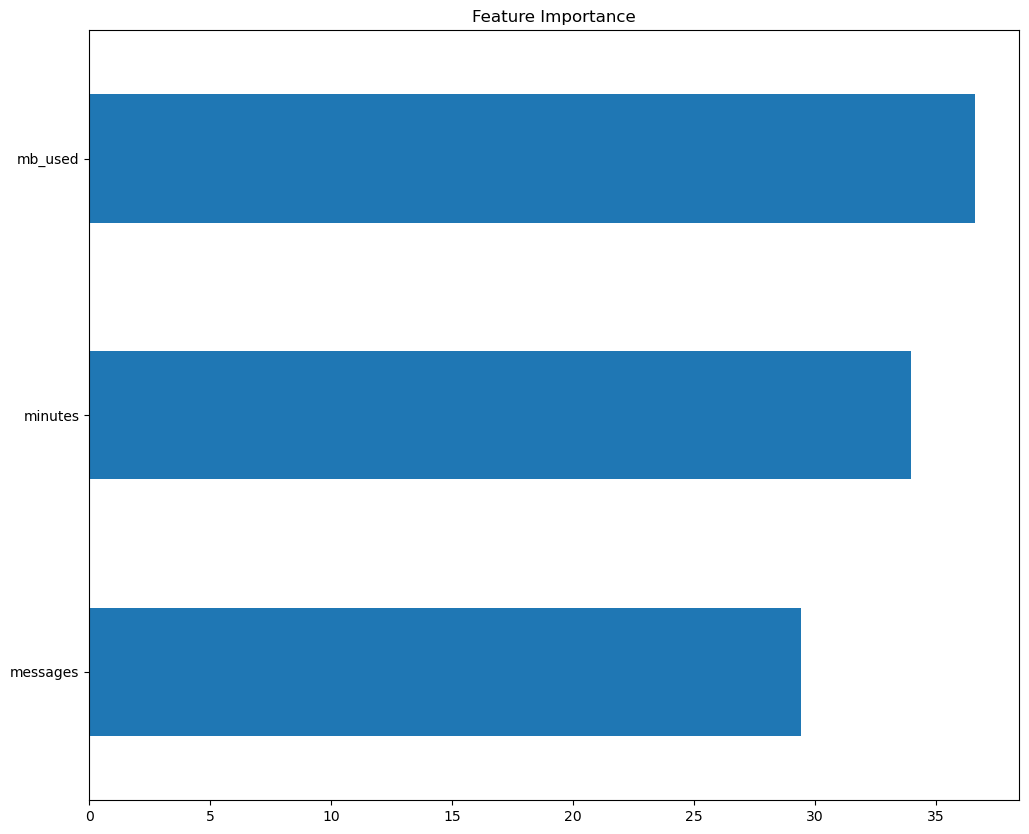

In [31]:
if best_model_name == 'CatBoostClassifier':
    importance = best_model.best_estimator_.feature_importances_           # получаем коэффициенты важности признаков
elif best_model_name == 'LogisticRegression':
    importance = best_model_lr.best_estimator_._final_estimator.coef_[0]   # получаем коэффициенты важности признаков
else:
    # получаем коэффициенты важности признаков
    importance = best_model_rfc.best_estimator_._final_estimator.feature_importances_
# создаем датафрейм из 10 важнейших признаков
importance_features = pd.Series(importance, index=X_train.columns).sort_values(ascending=True).tail(10)
plt.figure(figsize=(12,10))                                                # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')         # визуализируем диаграмму
plt.show()

Наиболее важный признак - израсходованный интернет-трафик.

**Вывод:**  
Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier.  
Модель с наибольшим значением Accuracy - CatBoostClassifier.  
Метрики лучшей модели:  
 - accuracy: 0.868;  
 - recall: 0.634;  
 - f1: 0.746;  
 - roc_auc: 0.814;  
 - время обучения (секунд): 404.30;  
 - время предсказания (секунд): 0.002.  
 
Параметры лучшей модели:  
 - depth - 6.  
 
Наиболее важный признак - израсходованный интернет-трафик.

[Вернуться к содержанию](#start) 

## Тестирование лучшей модели
<a id="section_5"></a>

**Расчёт метрик лучшей модели на тестовой выборке**

Находим оптимальный порог и визуализируем ROC Curve:

Best Threshold=0.352321, G-Mean=0.745


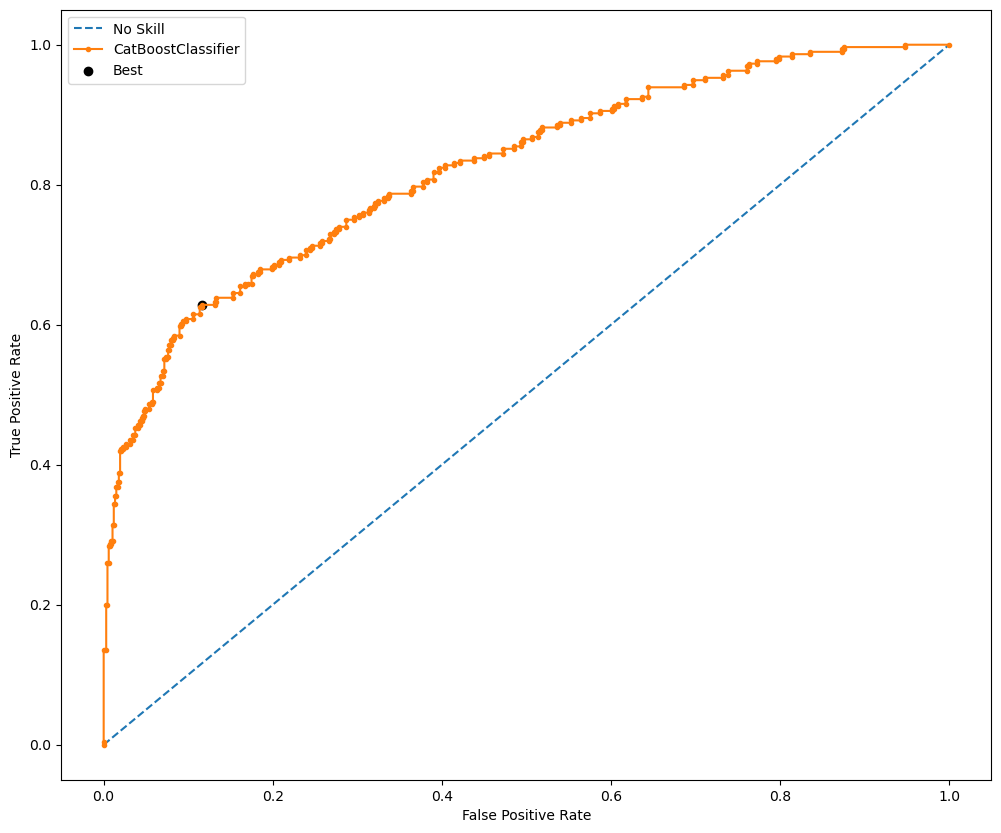

In [37]:
yhat = best_model.predict_proba(X_test)
yhat = yhat[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.figure(figsize=(12,10)) 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label=best_model_name)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Получаем предсказанния целевой переменной с учетом оптимального порога:

In [33]:
y_pred_optimal = np.where(yhat < thresholds[ix], 0, 1)

Рассчитываем метрики на тестовой выборке:

In [34]:
roc_auc = roc_auc_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
accuracy = accuracy_score(y_test, y_pred_optimal)
print('Roc-Auc: {:.3f}'.format(roc_auc))
print('Recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('Accuracy: {:.3f}'.format(accuracy))

Roc-Auc: 0.756
Recall: 0.628
F1: 0.664
Accuracy: 0.805


**Матрица ошибок**

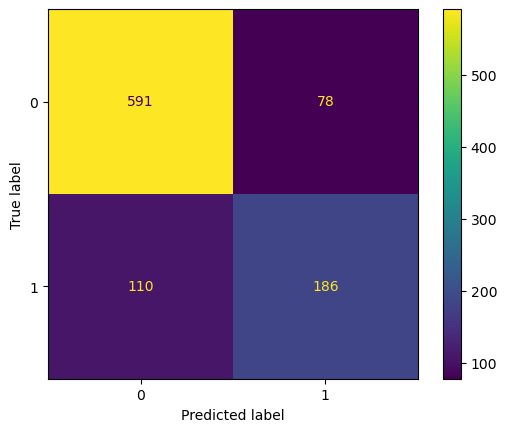

In [35]:
cm = confusion_matrix(y_test, y_pred_optimal)                                   # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Проверка модели на адекватность**

In [36]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RS)
dummy_clf.fit(X_test, y_pred_optimal)
dummy_accuracy = dummy_clf.score(X_test, y_pred_optimal)
if accuracy > dummy_accuracy:
    print('Accuracy для выбранной модели ({:.3f}) выше, чем accuracy для "наивного" алгоритма ({:.3f}). Модель можно считать адекватной.'
          .format(accuracy, dummy_accuracy))
else:
    print('Accuracy для выбранной модели ({:.3f}) не выше, чем accuracy для "наивного" алгоритма ({:.3f}).\n Модель нельзя считать адекватной.'
          .format(accuracy, dummy_accuracy))

Accuracy для выбранной модели (0.805) выше, чем accuracy для "наивного" алгоритма (0.726). Модель можно считать адекватной.


**Вывод:**  
1. Метрики лучшей модели на тестовой выборке:  
 - Roc-Auc: 0.756;
 - Recall: 0.628;
 - F1: 0.664;
 - Accuracy: 0.805.  

2. Accuracy для выбранной модели (0.762) выше, чем accuracy для "наивного" алгоритма (0.726), модель можно считать адекватной.  

[Вернуться к содержанию](#start) 

## Общий вывод
<a id="section_6"></a>

**Загрузка данных и общая информация**  

1. В датафрейме содержатся 3214 строк и 5 столбцов. Объем датафрейма - 125.7 KB.
2. Параметры "calls", "minutes", "messages", "mb_used" имеют тип "float64", а "is_ultra" - "int64".
3. Пропущенные значения отсутствуют.
4. Пользователей тарифа "Ультра" от общего количества представленных в датафрейме пользователей - 30.6%.


**Исследовательский анализ данных**

1. У тарифа "Ультра" больше и диапазон распределения значений и медианы признаков.  
У обоих тарифов присутствуют выбросы значений признаков за первый и третий квантили. Но если тарифы предусматривают возможность пользования услугами в таких объемах, считать эти выбросы аномальными значениями нельзя.
2. Распределения признаков имеют положительную асимметрию.  
Тариф "Ультра" имеет более пологое распределение признаков.  
У тарифа смарт наблюдаются ярковыраженные пики:  
- calls: 25-100;
- minutes: 190-700;
- mb_used: 10000-25000.
3. Высокий уровень корреляции наблюдается у признаков "calls" и "minutes". На основании этого признак "calls" исключен из исследования.


**Исследование моделей**  

Рассмотрены модели LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier.  
Модель с наибольшим значением Accuracy - CatBoostClassifier.  
Метрики лучшей модели:  
 - accuracy: 0.868;  
 - recall: 0.634;  
 - f1: 0.746;  
 - roc_auc: 0.814;  
 - время обучения (секунд): 404.30;  
 - время предсказания (секунд): 0.002.  
 
Параметры лучшей модели:  
 - depth - 6.  
 
Наиболее важный признак - израсходованный интернет-трафик. 

 
**Проверка лучшей модели**  

1. Метрики лучшей модели на тестовой выборке:  
 - Roc-Auc: 0.756;
 - Recall: 0.628;
 - F1: 0.664;
 - Accuracy: 0.805.  

2. Accuracy для выбранной модели (0.762) выше, чем accuracy для "наивного" алгоритма (0.726), модель можно считать адекватной.    

[Вернуться к содержанию](#start) 